# 병합된 데이터로 Dual_Attention_LSTM 훈련

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

seed_value = 743
print("Train with random seed", seed_value)

import os
os.environ['PYTHONHASHSEED'] = str(seed_value)
import random
random.seed(seed_value)
import numpy as np
np.random.seed(seed_value)
import tensorflow as tf
tf.random.set_seed(seed_value)
from tensorflow.keras import backend as K

Train with random seed 743


In [3]:
import warnings
warnings.filterwarnings('ignore')

import joblib 
import pandas as pd
from tqdm import trange
import matplotlib.pyplot as plt
import matplotlib

In [4]:
from tensorflow.keras.models import *
from tensorflow.keras.layers import Lambda, RepeatVector
from tensorflow.keras.layers import Input, multiply
from tensorflow.keras.layers import Dense, LSTM, Dropout, Flatten, Permute, Concatenate
from tensorflow.keras import regularizers

In [6]:
def calculate_smape(actual, predicted) -> float:
    if not all([isinstance(actual, np.ndarray), 
                isinstance(predicted, np.ndarray)]):
        actual, predicted = np.array(actual),
        np.array(predicted)

    return round(
        np.mean(
            np.abs(predicted - actual) / 
            ((np.abs(predicted) + np.abs(actual))/2)
        )*100, 2
    )

## 훈련할 데이터 경로 load

In [7]:
data_path = '../Merged_Data'

In [8]:
train_x_df = pd.read_csv(os.path.join(data_path, 'train_x.csv'))
train_y_df = pd.read_csv(os.path.join(data_path, 'train_y.csv'))
test_x_df = pd.read_csv(os.path.join(data_path, 'test_x.csv'))
test_y_df = pd.read_csv(os.path.join(data_path, 'test_y.csv'))
valid_x_df = pd.read_csv(os.path.join(data_path, 'valid_x.csv'))
valid_y_df = pd.read_csv(os.path.join(data_path, 'valid_y.csv'))

## 모델에 입력할 형태로 데이터 변환(window_size=24)

In [9]:
def create_dataset(X, y, window_size=24):
    data_x, data_y = [], []
    assert len(X) == len(y)
    for i in range(len(X) - window_size + 1):
        input_data = X[i: i + window_size, :]
        target_data = y[i + window_size - 1, 0]
        data_x.append(input_data)
        data_y.append(target_data)

    return np.array(data_x), np.array(data_y)

In [10]:
train_X, train_y = create_dataset(train_x_df.values, train_y_df.values)
test_X, test_y = create_dataset(test_x_df.values, test_y_df.values)
valid_X, valid_y = create_dataset(valid_x_df.values, valid_y_df.values)

In [11]:
print(train_X.shape, train_y.shape)
print(valid_X.shape, valid_y.shape)
print(test_X.shape, test_y.shape)

(55204, 24, 5) (55204,)
(3045, 24, 5) (3045,)
(3046, 24, 5) (3046,)


## Dual_Attention_LSTM 모델 정의

In [12]:
def feature_attention_block(inputs, input_dim, single_attention_vector):
    time_steps = int(inputs.shape[1])  # 4
    a = Dense(input_dim, activation='softmax', name='feature_attention_vec')(
        inputs)  # (batch_size, input_dim, time_step)
    if single_attention_vector:
        a = Lambda(lambda x: K.mean(x, axis=1), name='feature_dim_reduction')(a)  # (batch_size, input_dim)
        a = RepeatVector(time_steps)(a)  # (batch_size, input_dim, time_step)
    output_attention_mul = multiply([inputs, a], name='feature_attention_mul')
    return output_attention_mul

In [13]:
def time_attention_block(inputs, input_dim, single_attention_vector):
    feature_num = int(inputs.shape[2])  # 4
    time_steps = int(inputs.shape[1])
    a = Permute((2, 1))(inputs)
    a = Dense(time_steps, activation='softmax', name='time_attention_vec')(a)  # (batch_size, input_dim, time_step)
    if single_attention_vector:
        a = Lambda(lambda x: K.mean(x, axis=1), name='time_dim_reduction')(a)  # (batch_size, input_dim)
        a = RepeatVector(feature_num)(a)  # (batch_size, input_dim, time_step)
    a = Permute((2, 1))(a)
    output_attention_mul = multiply([inputs, a], name='time_attention_mul')
    return output_attention_mul

In [14]:
def model_attention_applied_before_lstm(time_step, feature_num, batch_size, input_dim, single_attention_vector):
    # inputs = Input(batch_shape=(batch_size, time_step, feature_num))
    inputs = Input(shape=(time_step, feature_num))
    time_x = time_attention_block(inputs, input_dim, single_attention_vector)
    feature_x = feature_attention_block(inputs, input_dim, single_attention_vector)
    x = Concatenate(axis=2)([time_x, feature_x])
    x = LSTM(6, activation='tanh',
             stateful=False,
             return_sequences=True,
             kernel_initializer='he_normal')(x)
    x = Dropout(0.2)(x)
    x = Flatten()(x)
    x = Dense(10, activation='linear', kernel_regularizer=regularizers.l2(0.01),
              activity_regularizer=regularizers.l1(0.))(x)
    output = Dense(1, activation='linear', kernel_initializer='he_normal')(x)

    # model = Model(input=[inputs], output=output)
    model = Model(inputs=[inputs], outputs=output)
    return model

## 하이퍼 파라미터 정의

In [15]:
batch_size = 4
look_back = 24
feature_num = 5
SINGLE_ATTENTION_VECTOR = True

model = model_attention_applied_before_lstm(look_back, feature_num, batch_size, feature_num, SINGLE_ATTENTION_VECTOR)
model.compile(loss='mean_squared_error', optimizer='adam')

## 모델 훈련(epoch=100)

In [16]:
history = model.fit(train_X, train_y,
                    validation_data=(valid_X, valid_y),
                    batch_size=batch_size, epochs=100)

Epoch 1/100
13801/13801 [==============================] - 52s 4ms/step - loss: 0.0134 - val_loss: 0.0055
Epoch 2/100
13801/13801 [==============================] - 48s 3ms/step - loss: 0.0076 - val_loss: 0.0056
Epoch 3/100
13801/13801 [==============================] - 57s 4ms/step - loss: 0.0070 - val_loss: 0.0049
Epoch 4/100
13801/13801 [==============================] - 50s 4ms/step - loss: 0.0066 - val_loss: 0.0047
Epoch 5/100
13801/13801 [==============================] - 50s 4ms/step - loss: 0.0063 - val_loss: 0.0046
Epoch 6/100
13801/13801 [==============================] - 50s 4ms/step - loss: 0.0062 - val_loss: 0.0045
Epoch 7/100
13801/13801 [==============================] - 51s 4ms/step - loss: 0.0061 - val_loss: 0.0047
Epoch 8/100
13801/13801 [==============================] - 50s 4ms/step - loss: 0.0060 - val_loss: 0.0046
Epoch 9/100
13801/13801 [==============================] - 48s 3ms/step - loss: 0.0060 - val_loss: 0.0048
Epoch 10/100
13801/13801 [====================

## 모델 저장, test set 예측 결과 확인

In [17]:
model.save('./Saved_Model/Dual_Attention_LSTM(epoch=100).pt')

train_predict = model.predict(train_X, batch_size)
valid_predict = model.predict(valid_X, batch_size)
test_predict = model.predict(test_X, batch_size)

INFO:tensorflow:Assets written to: ./Saved_Model/Dual_Attention_LSTM(epoch=100).pt\assets


INFO:tensorflow:Assets written to: ./Saved_Model/Dual_Attention_LSTM(epoch=100).pt\assets


## sclaer를 불러와서 inverse transform 적용

In [24]:
scaler = joblib.load('../Merged_Data/Scaler/Y_pm10.pkl')

inv_test_y = scaler.inverse_transform(test_y.reshape(-1, 1))
inv_test_predict = scaler.inverse_transform(test_predict)

## 성능 평가 : SMAPE

In [30]:
test_smape = calculate_smape(inv_test_y, inv_test_predict)

In [31]:
print("Test SMAPE: %.2f" % test_smape)

Train SMAPE: 18.76
Valid SMAPE: 25.30
Test SMAPE: 15.46


## 결과 시각화

In [36]:
def vizualization_self(train_term,name,test_y,pred_y):
    plt.figure(figsize=(32, 16))
    
    plt.plot(np.arange(train_term), test_y[:train_term], color='red', ls='-', lw=3, label='Raw Data')
    plt.plot(np.arange(train_term), pred_y[:train_term], color='blue', ls='--', lw=3, label='Raw Data')
    
    plt.xlabel('[Time]', fontsize=25, fontweight='bold')
    plt.ylabel('[PM10]', fontsize=25, fontweight='bold')
    plt.title('Prediction Visualization({:s})'.format(name),fontsize=30, weight='bold')
    plt.xticks( fontsize=15, fontweight='bold')
    plt.yticks( fontsize=15, fontweight='bold')
    plt.grid(True)
    plt.legend()
    return

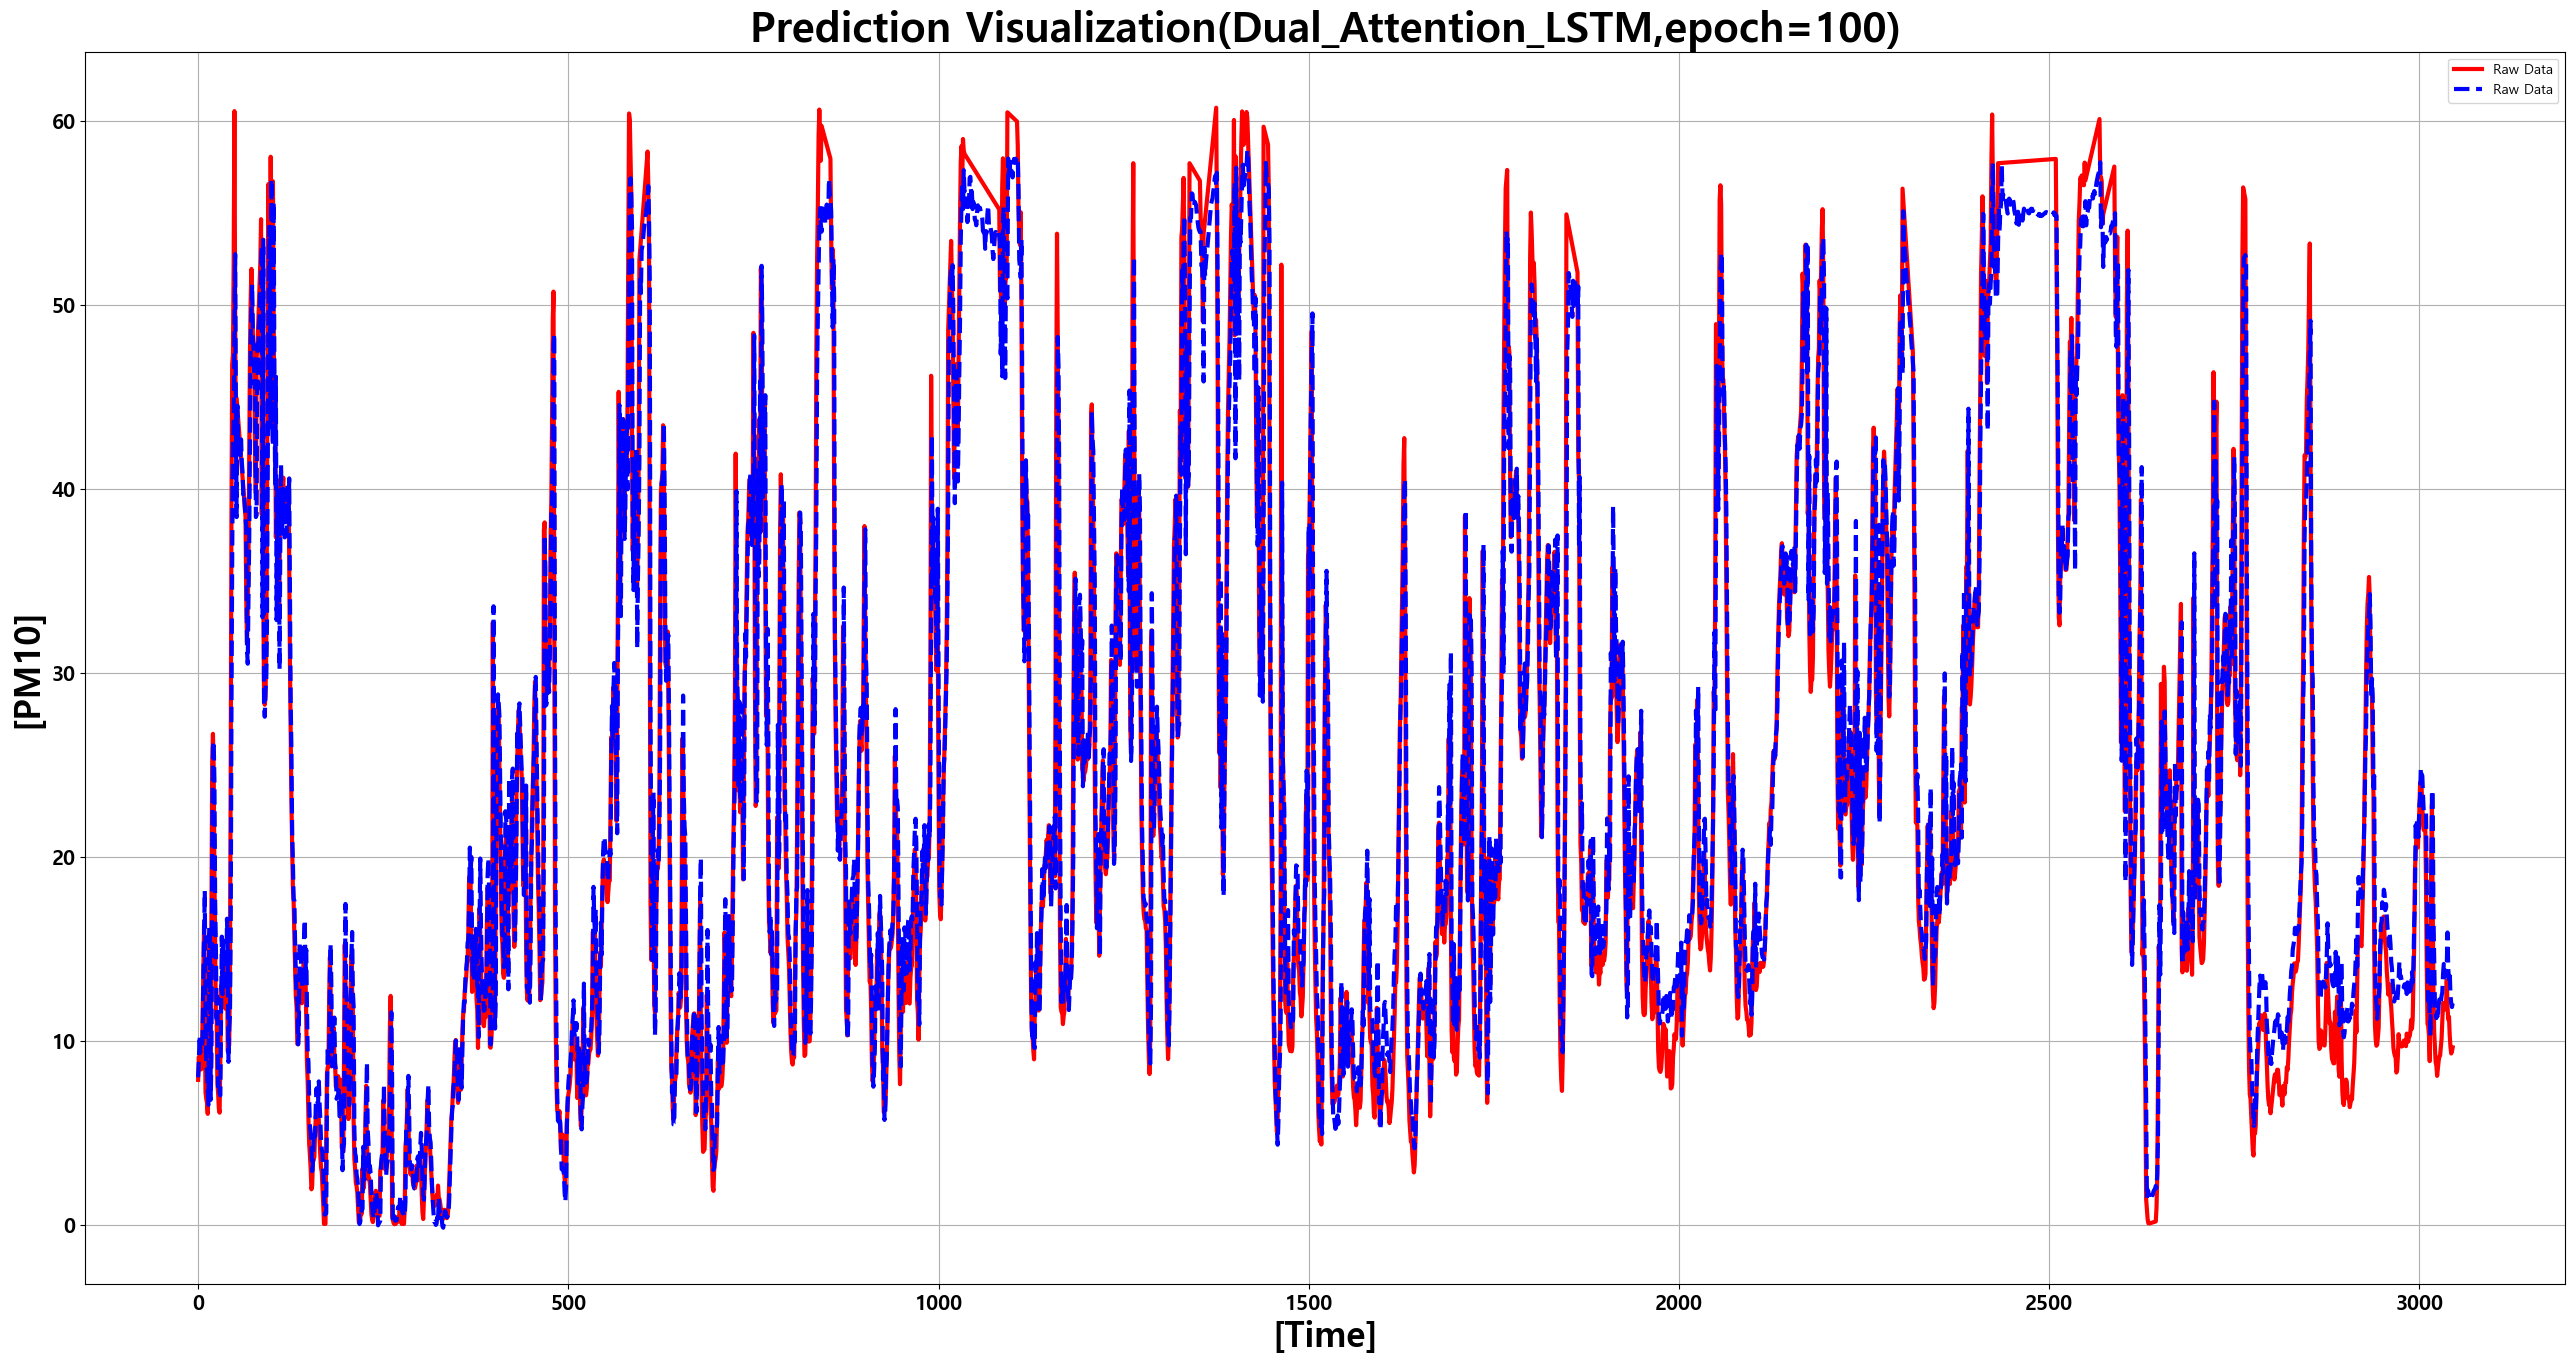

In [37]:
vizualization_self(len(inv_test_y),'Dual_Attention_LSTM,epoch=100',inv_test_y,inv_test_predict)

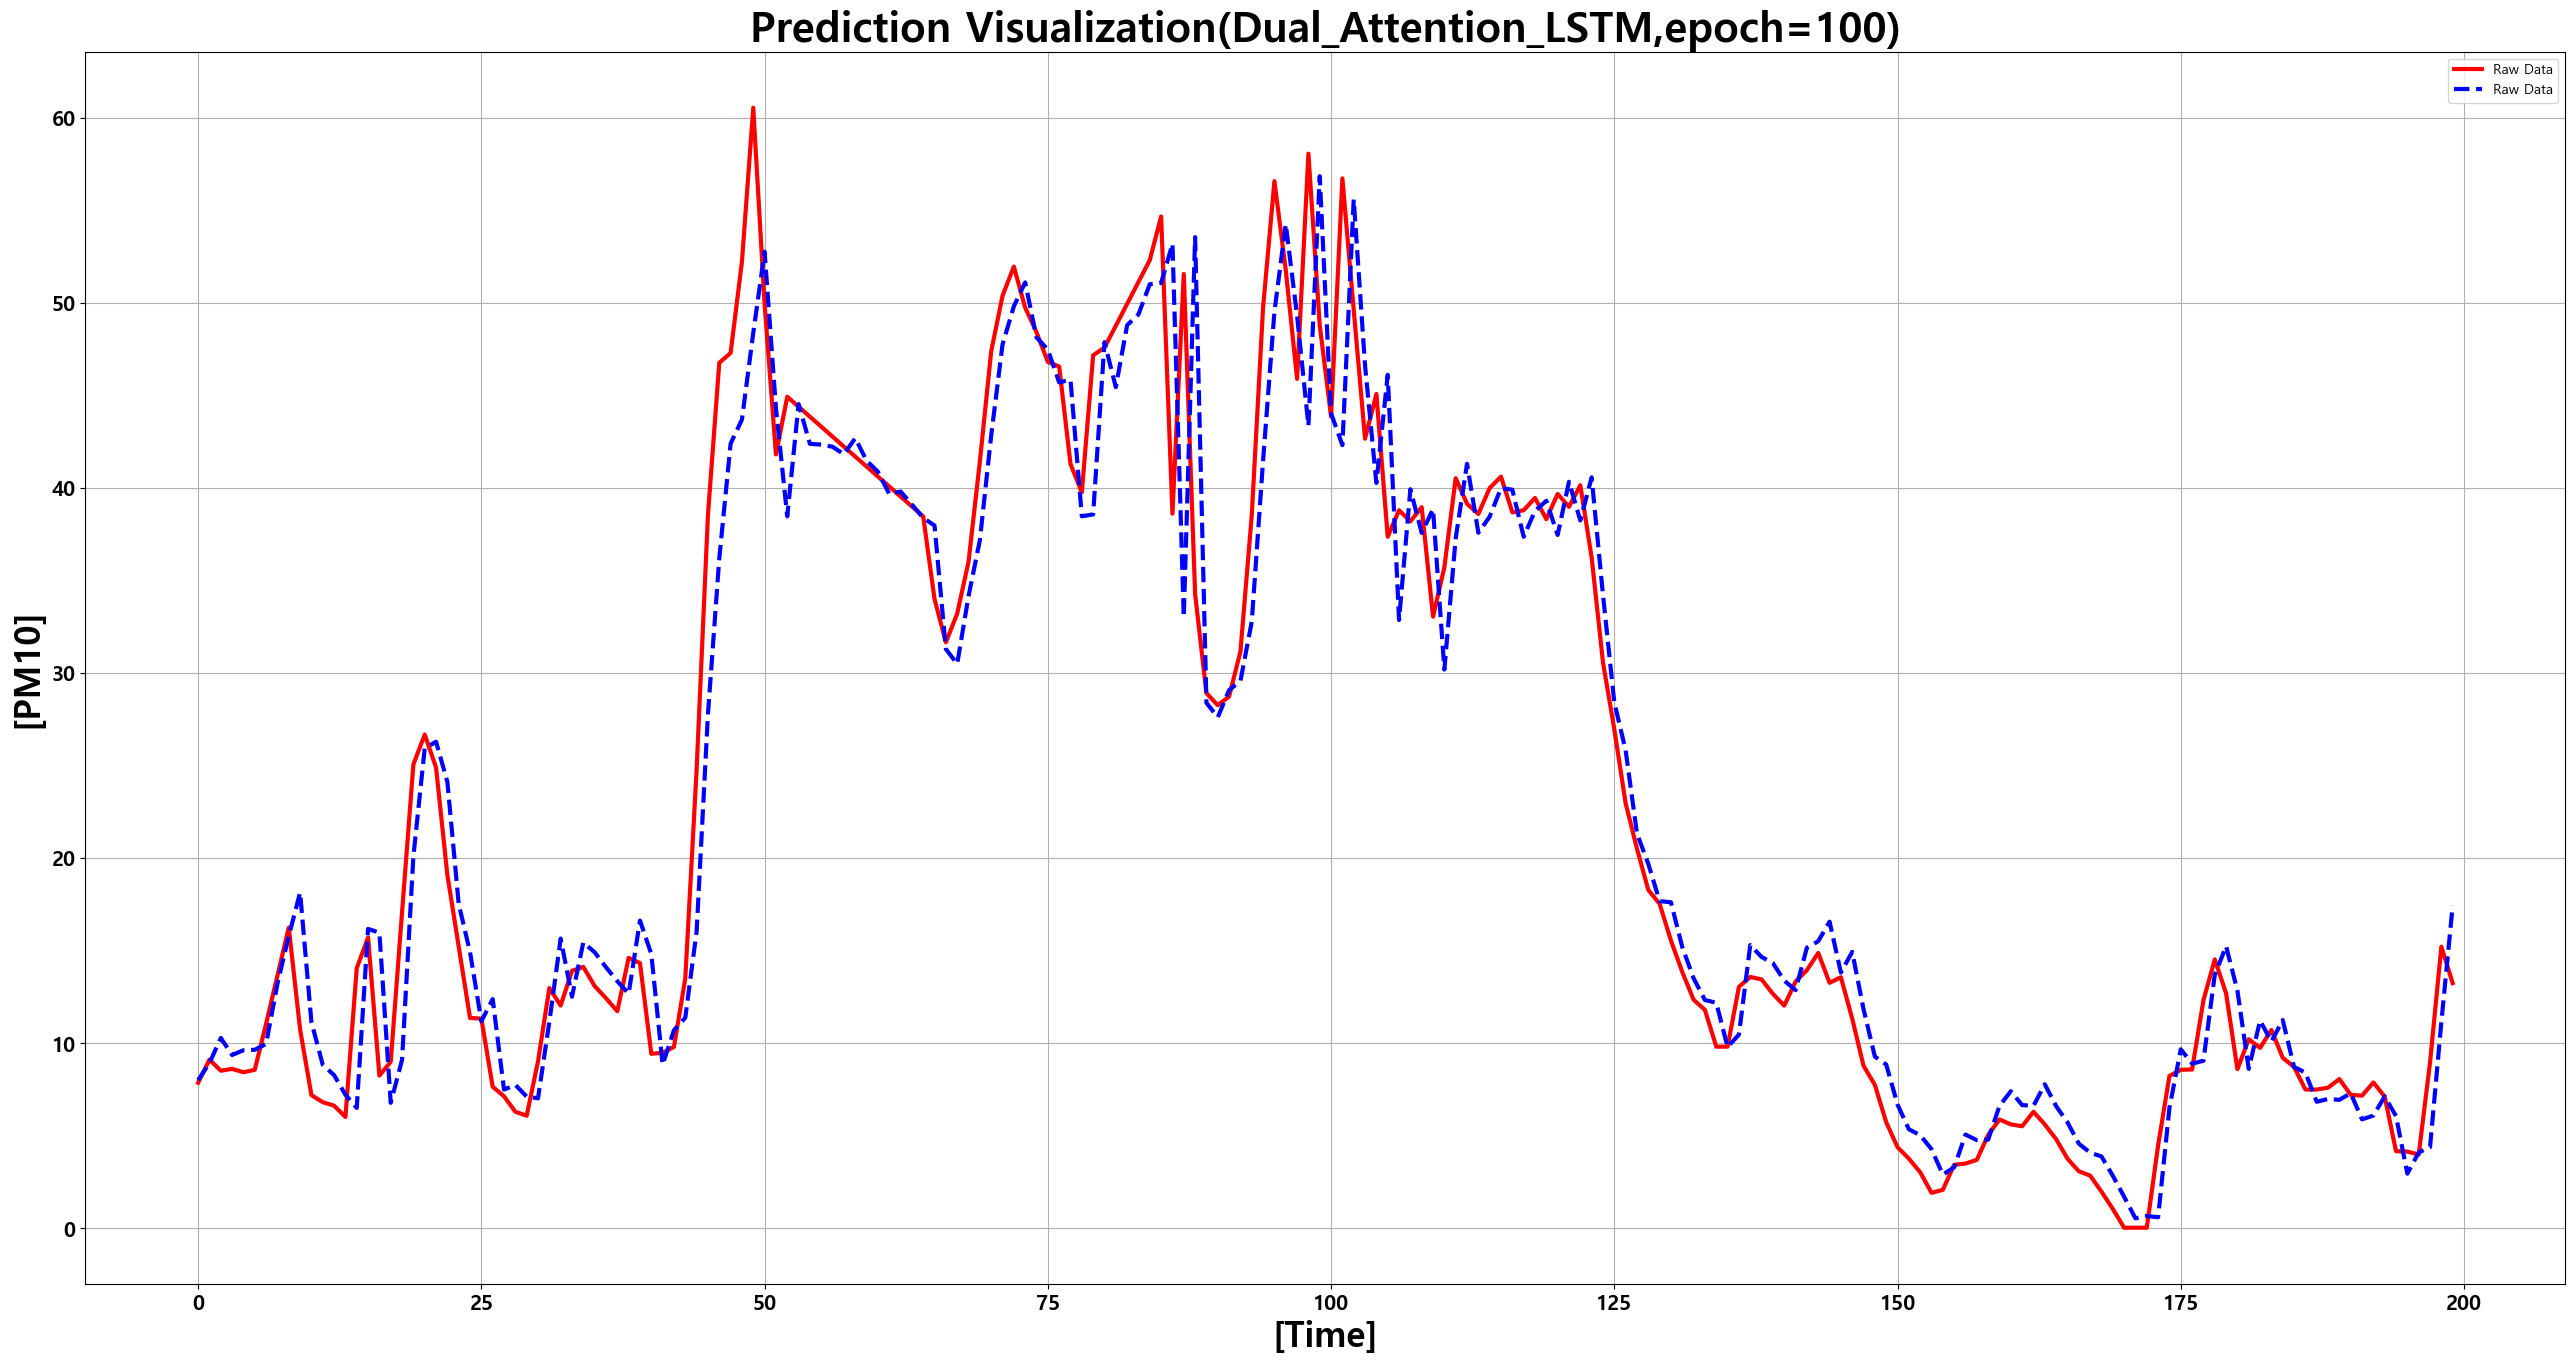

In [38]:
vizualization_self(200,'Dual_Attention_LSTM,epoch=100',inv_test_y,inv_test_predict)